In [2]:
# Machine Learning
# Currently set for breast cancer data
# make sure the data is classified numerically (e.g. 10 classifications = output column with 0,1,...,8,9)
# Three algorithms shown here
# 1. Linear Regression
# 2. Logistic Regression
# 3. Neural Network (can change number of hidden layers, nodes per hidden layer, etc)
# 4. K-Means


filename = r'C:\Users\Alan Horst\MachineLearningNg\PythonML\data\BreastCancerdata.csv'
#filename = r'C:\Users\Alan Horst\MachineLearningNg\PythonML\data\ex1data2.csv'

In [3]:
import pandas as pd
import numpy as np
import math
import scipy
dataBC = pd.read_csv(filename)
dataBC.head()

Linear_Regression = 1
Logistic_Regression = 1
Neural_Network = 1
K_Means = 1

In [4]:
#Choose Data to Input
#DataInputx = ['area', 'occupants']
DataInputx = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
dataBC_X = dataBC[DataInputx].copy()

#Feature Scaling
for i in range(0,len(DataInputx)):
    mean = dataBC_X[DataInputx[i]].mean(axis=0)
    std = dataBC_X[DataInputx[i]].std(axis=0)
    def Norm(df):
        return (df[DataInputx[i]]-mean)/std
    dataBC_X[DataInputx[i]] = dataBC_X.apply(Norm, axis=1)
dataBC_X['zeroeth'] = 1

## Turns string classes into numerical ids ('classtonum' dictionary contains class to numeric translation)
if Logistic_Regression == 1 or Neural_Network == 1 or kmeans == 1:
    uniq = dataBC.diagnosis.unique()
    classtonum = {k : [] for k in uniq}
    for i in range(dataBC.diagnosis.nunique()):
        classtonum[uniq[i]].append(i)
    print('Class to Numeric Representation:')
    print(classtonum)
    dataBC.diagnosis = [int(classtonum[item][0]) for item in dataBC.diagnosis]

dataBC_Y = dataBC[['diagnosis']].copy()
Xtot = dataBC_X.values
X = Xtot[0:400,:] #Learning Set
ytot = dataBC_Y.values
y = ytot[0:400,:]
Xtest = Xtot[400:,:] #Test Set
ytest = ytot[400:,:]
n = len(X[0,:])
m = len(y[:,0])

Class to Numeric Representation:
{'M': [0], 'B': [1]}


In [5]:
#Principal Component Algorithm (Reduces dimensions of data)
def PCA(X):
    sigma = 1/m * (X.conj().T @ X)
    U,S,V =np.linalg.svd(sigma) #Least Squares
    I = (abs(U[0]) >= 0.05)*1
    Im = DataInputx
    for j in range(len(I)):
        if I[j] == 0:
            Im[j] = 'Unimp'
    Im = [item for item in Im if item != 'Unimp']
    i = 1
    while 1-sum(S[0:i])/sum(S) >= .01: #Continues until varance is small enough (1%) from true data
        if 1-sum(S[:-1])/sum(S) >= .01:
            print("No Reduction Found")
            Z = X
            break
        i+=1
        if 1-sum(S[0:i])/sum(S) <= .01:
            K = i
            print("Dimensions reduced from %d to %d" % (n,K))
            #print("Unreduced features that contributed at least 20% to most important reduced feature...")
            print(Im)
            Z = X @ U[:, 0:K] #New reduced dataset Z to replace X
            Ztest = Xtest @ U[:, 0:K] #Apply same reduction to test set (does not perform the reduction using this data)
            break
    return Z,Ztest
#Comment this out if you do not want to reduce 
X,Xtest = PCA(X)

Dimensions reduced from 18 to 11
['radius_mean', 'texture_mean', 'perimeter_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [6]:
# F-Score
# An f-score often gives a better idea of how accurate our prediction is, especially if there are few positive examples
def fscore(pred,y):
    diff = y - 2*pred
    tp = sum(diff == -1) #true positives
    fp = sum(diff == -2) #false positives
    fn = sum(diff == 1)  # false negatives
    prec = tp/(tp+fp)    # precision
    rec = tp/(tp+fn)     # recall
    Fscore = 2*prec*rec/(prec+rec) #fscore
    return Fscore

In [7]:
n = len(X[0,:]) #Reinitialize n, m from reduced data
m = len(y[:,0])

In [8]:
if Linear_Regression == 1:
    # Some gradient descent settings
    num_iters = 1500
    alpha = 0.01
    theta = np.zeros((n,1))
    J = 1/(2*m) * sum(np.square((X.dot(theta))-y)) #cost function
        
    J_history = []
    iter = 0
    while iter < num_iters:
        temp = theta
        theta = temp - (alpha/(m) * sum(((X.dot(theta)-y).T).dot(X))).reshape((-1, 1)) #find optimal theta (weight)
        #np.append(J_history, computeCost(X, y, theta))
        iter += 1
    print('Theta Result:')
    print(theta)
    test = X[3]
    print('Algorithm Test Result:')
    print(np.dot(theta.T,test))
    print('Actual Result')
    print(y[3])

Theta Result:
[[ 0.11328797]
 [-0.0347924 ]
 [-0.20043063]
 [ 0.52723893]
 [-0.06016648]
 [ 0.18725119]
 [ 0.04275894]
 [ 0.06386074]
 [ 0.05342147]
 [-0.10847571]
 [-0.07918015]]
Algorithm Test Result:
[0.00025187]
Actual Result
[0]


In [9]:
from scipy.optimize import minimize
regularization = 1 #To minimize effect of overfitting, set = 1
if Logistic_Regression == 1:
    mtest = len(ytest[:,0])
    iterations = 1500;
    alpha = 0.01;
    theta = np.zeros(n)
    initial_theta = np.zeros((n,1))
    def sigmoid(x): #returns sigmoid, numbers >> 0 give 1, numbers << 0 give 0
        return 1/ (1 + np.exp(-x))
    def h(x, theta): #predicted output
        return np.array(sigmoid(np.dot(x, theta)))
    sigmoid = np.vectorize(sigmoid)
    def costFunction(theta,x,y, lambda_):

        p1 = np.dot(y.T, np.log(h(x, theta)).reshape(m,1))
        p2 = np.dot((np.ones((m,1)) - y).T, np.log( 1 - h(x, theta)).reshape(m,1))
        summ = (p1 + p2)
        J = -summ[0]/m #cost function
        if regularization == 1: #regularizes the cost, to minimize possibly uneeded/overfitting theta
            reg_J = lambda_/(2*m)*sum(np.square(theta[1:]))
            J[1:] = J[1:] + reg_J


        return J
    def gradientVect(theta, x, y, lambda_): #computes gradient for optimization
        gradient = []

        theta = theta.reshape(n,1)

        beta = h(x, theta) - y #prediction vs actual
        
        grad = np.dot(X.T, beta) * 1./m

        if regularization == 1: #regularization for grad
            reg = theta[1:] * lambda_/m
            grad[1:] = grad[1:] + reg

        return grad.flatten()
        
    def optimizeTheta(x, y, nLabels, lambda_):

        for i in np.arange(0, nLabels):
            theta = np.zeros((n,1))
            #scipy minimize takes the cost, gradient, theta and our data and finds an optimal minimum
            res = minimize(costFunction, theta, args=(x, (y == i)*1, lambda_), method='BFGS',
                       jac=gradientVect, options={'maxiter':300})
        return res
    res = optimizeTheta(X,y,1,0.5) #learning parameter lambda set to 0.5, but good to iterate and check many lambda vals
    pred = np.around(sigmoid(Xtest @ (res.x)[:, None])) #rounds up or down from 0.5, depending on problem this may need changing
    pred=1-pred
    diff = pred - ytest
    fin = 100*(1-np.count_nonzero(diff)/mtest)
    fs = fscore(pred, ytest)
    print("Predictions on test set %f %% accurate." %fin)
    print("Fscore: %f" %fs)

Predictions on test set 95.857988 % accurate.
Fscore: 0.972332


In [11]:
import scipy
regularization = 1 #To minimize effect of overfitting, set = 1
if Neural_Network == 1:
    iterations = 500
    nodes = 10
    alpha = 0.01
    num_layers = 2 #This can be increased/decreased, keep complexity of data in mind, look out for overfitting/computation time
    epsilon_init = 0.12
    classes = len(np.unique(y))
    Y = np.zeros((classes,m))
    
    for i in range(0,m-1): #turns our output into vectors for each example
        ytemp = np.zeros((classes,1))
        position = [y[i]]
        ytemp[position] = 1
        Y[:,i] = ytemp[:,0]
        
    #This randomizes the int weights, otherwise the neural network will have no basis to start (no diff between each node)
    def randInitWeights(L_out,L_in):
        return np.random.rand(L_out,L_in)*2*epsilon_init-epsilon_init
    
    theta = []
    theta_init = []
    for i in range(0,num_layers+1): #we have to initialize the layers to match our chosen structure and data
        if i == 0:
            theta = [np.zeros((nodes,n))] #matches the data features and the nodes of first layer
            timatx = randInitWeights(nodes,n)
            theta_init = [timatx]
        elif i == num_layers:
            tmatx = np.zeros((classes,nodes+1)) #matches the number of output classes and nodes from last layer
            theta.append(tmatx)
            timatx = randInitWeights(classes,nodes+1)
            theta_init.append(timatx)
        else:
            tmatx = np.zeros((nodes,nodes+1)) #hidden layer interactions (notice added bias node)
            theta.append(tmatx)
            timatx = randInitWeights(nodes,nodes+1)
            theta_init.append(timatx)

            
    def sigmoid(x): #sigmoid function again
        return 1/ (1 + np.exp(-x))
    sigmoid = np.vectorize(sigmoid)
    
    def sigmoid_grad(x): #derivative of sigmoid function for grad
        return np.dot(sigmoid(x), (1-sigmoid(x)))
    sigmoid_grad = np.vectorize(sigmoid_grad)
    
    def unroll(theta): #unrolls the weights into a long vector (not used here, but often needed for min function)
        for n in range(0,num_layers+1):
            if n == 0:
                unrolled = (theta[n].flatten())
            else:
                unrolled = np.append(unrolled,theta[n].flatten())
        return unrolled
    
    def fwd(theta,x,y,n,i): #forward propogation (makes a guess)
        if n == 0:
            return np.insert(sigmoid(theta[n]@x[i,:].conj().T),0,1)
        elif n==num_layers:
            return sigmoid(theta[n]@fwd(theta,x,y,n-1,i))
        else:
            return np.insert(sigmoid(theta[n]@fwd(theta,x,y,n-1,i)),0,1)
        
    def costFunction(theta,x,y,lambda_): #computes the cost using fwd prop
        summ=0
        for i in range(0,m):
            p1 = np.dot(y[:,i], np.log(fwd(theta,x,y,num_layers,i)))
            p2 = np.dot((1 - y[:,i]),np.log(1 - fwd(theta,x,y,num_layers,i)))
            temp = (p1 + p2)
            summ += temp
        J = -summ/m
        if regularization == 1: #applies regularization to reduce overfitting
            sumreg = 0
            for i in range(1,num_layers):
                sumreg += sum(np.square(theta[i]))
            reg_J = lambda_/(2*m)*(sumreg)
            J = J + reg_J
        return J
    
    def bck(theta,x,y,n,i): #back propogation (sends our errors back through the network)
        if n == 0:
            return (fwd(theta,x,y,num_layers,i) - y[:,i])
        elif n == num_layers:
            g_z = np.insert(sigmoid_grad(theta[0]@x[i,:]),0,1)
            d = theta[(num_layers+1)-n].conj().T@bck(theta,x,y,n-1,i)*g_z
            return d[1:]
        else:
            g_z = np.insert(sigmoid_grad(theta[(num_layers)-n]@fwd(theta,x,y,(num_layers-1)-n,i)),0,1)
            d = theta[(num_layers+1)-n].conj().T@bck(theta,x,y,n-1,i)*g_z
            return d[1:]    
        
    def gradientVect(theta, x, y, lambda_): #computes the gradient for optimization
        gradient = []
        theta_grad = []
        reg_theta = []
        for j in range(0,num_layers+1):
            for i in range(0,m):        
                    if j == 0:
                        if i == 0:
                            theta_grad = [np.outer(bck(theta,x,y,num_layers,i), x[i,:].conj().T)]
                        else:
                            theta_grad[0] += np.outer(bck(theta,x,y,num_layers,i), x[i,:].conj().T)
                    else:
                        if i == 0:
                            theta_grad.append(np.outer(bck(theta,x,y,(num_layers)-(j),i), fwd(theta,x,y,j-1,i).conj().T))
                        else:
                            theta_grad[j] += np.outer(bck(theta,x,y,(num_layers)-(j),i), fwd(theta,x,y,j-1,i).conj().T)
        for i in range(0,num_layers+1):
            theta_grad[i] = 1/m*(theta_grad[i])
            if regularization == 1:
                if i == 0:
                    reg_theta = [lambda_/m*(theta[i])]
                    theta_grad[i][:,1:] += reg_theta[i][:,1:]
                else:
                    reg_theta.append(lambda_/m*(theta[i]))
                    theta_grad[i][:,1:] += reg_theta[i][:,1:]
        grad = theta_grad
        return grad
    
    theta_grad = gradientVect(theta_init, X, Y, 0.9)
    initial_nn_params = unroll(theta_init)

    def optimizeTheta(x, y, theta, alpha, num_iters, lambda_): #basic gradient descent to find minima
        J_history = []
        for i in range(num_iters):
            cost = costFunction(theta,x,y,lambda_)
            theta_grad = gradientVect(theta, x, y, lambda_)
            theta_fin = theta
            J_history.append(cost)
            for n in range(0,num_layers+1):
                    theta_fin[n] = theta_fin[n] - (alpha*theta_grad[n])
        return theta_fin , J_history
                
    nnTheta, nnJ_history = optimizeTheta(X,Y,theta_init,0.8,400,0.9)

In [25]:
if Neural_Network == 1:
    z = len(ytest[:,0])
    Ytest = np.zeros((classes,z))
    
    for i in range(0,z-1): #vectorizes ytest output
        ytemp = np.zeros((classes,1))
        position = [ytest[i]]
        ytemp[position] = 1
        Ytest[:,i] = ytemp[:,0]
    
    def predict(theta,X): #uses the test data to see how well our network did
        h = []
        X0 = np.ones((z,1))
        for n in range(0,num_layers+1):
            if n == num_layers:
                h = sigmoid(h @ theta[n].conj().T)
            elif n==0:
                h = sigmoid(X @ theta[n].conj().T)
                h = np.hstack((X0,h))
            else:
                h = sigmoid(h @ theta[n].conj().T)
                h = np.hstack((X0,h))
        return h
    pred = predict(nnTheta,Xtest)
    prediction = np.around(pred)[:,0]
    yin = Ytest[0,:]
    out = yin == prediction
    fin = np.mean(1*out) * 100 #percentage of examples in dataset we predicted correctly.
    fs = fscore(prediction, yin)
    print('Test Data Set Accuracy...')
    print(fin)
    print("Fscore: %f" %fs)

Test Data Set Accuracy...
97.63313609467455
Fscore: 0.950000


Predictions on test set 90.500000 % accurate.
Fscore: 0.920502


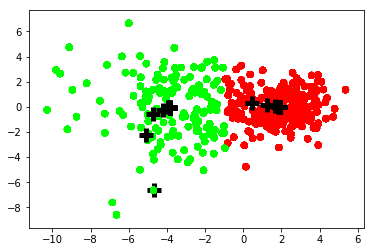

In [30]:
#K-means
import matplotlib.pyplot as plt
if K_Means == 1:
    k=2
    idx = np.zeros(m)
    temp = np.zeros(k)
    idex = np.random.randint(m, size=k)
    ctds = X[idex,:]
    def closestctd(X, ctds):
        for i in range(0,m):
            for j in range(0,k):
                temp[j] = np.linalg.norm(X[i,:] - ctds[j,:])**2
            I = list(temp).index(min(temp))
            idx[i] = I
        return idx
    def compctds(X, idx, k):
        for i in range(0,k):
            ck = (idx == i).sum()
            B = (idx == i).astype(int)
            Xi = X * B[:, None]
            ctds[i,:] = 1/ck * sum(Xi,1)
        return ctds
    def runKmeans(X, ctds, iter):
        ctds = ctds
        previous = ctds
        for i in range(0,iter):
            idx = closestctd(X, ctds)
            plotprogkmeans(X, ctds, previous, idx, k, i)
            ctds = compctds(X, idx, k)
        return ctds,idx
    def plotprogkmeans(X, ctds, previous, idx, K, i): #Markers show how centroids are updated over each iteration.
        colore = {0.0 : 'red', 1.0 : 'lime'}
        colors = np.vectorize(colore.__getitem__)(idx.T)
        plt.scatter(X[:,0],X[:,1],color = colors, zorder=1)
        plt.scatter(ctds[:,0], ctds[:,1], s=200, marker='+', linewidth=5, color='black', zorder=1+i)
    ctds,idx = runKmeans(X, ctds, 40)
    idx.shape = (m,1)
    pred = y - idx
    fin = 100*np.count_nonzero(pred)/m
    idx = 1 - idx
    fs = fscore(idx, y)
    print("Predictions on test set %f %% accurate." %fin)
    print("Fscore: %f" %fs)